In [1]:
RUN_RESTRICTED=True
LOCALPATH="../GIT/"

In [2]:
from __future__ import division, print_function, absolute_import

from IPython.core.display import SVG, HTML, Image, display
import sys
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from scipy.optimize import minimize

sys.path.append(LOCALPATH)

if not RUN_RESTRICTED:
    # External packages located at sys.path.append("../GIT/") 
    # These can be cloned or downloaded from:
    # https://github.com/riddhisw/predictiveest/tree/riddhisw-webinar/
    print("RUN_RESTRICTED:", RUN_RESTRICTED)
    print("LOCALPATH: ", LOCALPATH)
    print("[Loading akf, kf packages from LOCALPATH]")
    print("[akf, kf available at https://github.com/riddhisw/predictiveest/tree/riddhisw-webinar/]")
    from akf.armakf import autokf as arkf
    from kf.fast_3 import kf_2017
    from kf.common import calc_inst_params
    print("[Successfully loaded akf, kf packages from LOCALPATH]")

if RUN_RESTRICTED:
    print("RUN_RESTRICTED:", RUN_RESTRICTED)
    print("LOCALPATH: ", LOCALPATH)
    print("RUNNING RESTRICTED VERSION OF NOTEBOOK.")
    print("[akf, kf packages not loaded from LOCALPATH]")
    print("[akf, kf available at https://github.com/riddhisw/predictiveest/tree/riddhisw-webinar/]")

    
# Modules (.py) files located at './'
from chirp_models import *
from time_series_analysis_demo import kalman_filter, test_function, psd_ar, get_autoreg_model

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

RUN_RESTRICTED: True
LOCALPATH:  ../GIT/
RUNNING RESTRICTED VERSION OF NOTEBOOK.
[akf, kf packages not loaded from LOCALPATH]
[akf, kf available at https://github.com/riddhisw/predictiveest/tree/riddhisw-webinar/]


# Measurement Noise Filtering and Time Series Prediction in Python

-----------------------------
By Riddhi Gupta | riddhi.sw@gmail.com

#### Purpose:

The purpose of this webinar is to introduce techniques for time series analysis. In this webinar, I focus on the (linear) state space framework and the different ways we can use this framework to do **state estimation**, **noise filtering**, and **prediction** with time series data. These terms will be defined in due course. I assume no prior experience with time series analysis.

We often develop habits in how we want to analyze data quickly and sometimes being aware of other types of inference tools may be useful for a specific application. The purpose of *this workbook* and associated code is to provide more detail than what we can go through the webinar. It is meant as a collection of worked examples of time series analysis and references - happy to discuss via email about scope of current examples, alternative approaches, and/or corrections. 

#### Workbook Usage: 

1. Kernel --> Re-Start and Run All will run the entire workbook. 
2. By default, code cells are hidden. Toggle hidden code cells on/off (see top of workbook).
3. Within each Section, the code cells should be executed in order of presentation. 
4. To return to a previous Section, execute all code cells from the beginning of that Section. (Variable names have be re-used between Sections to connect with theory.)
5. Link to code and materials: https://github.com/riddhisw/equs_timeseries_webinar; reference list provided here. 
6. Section 3.3 requires external packages (akf, kf) and these can be obtained by downloading predictiveest repo from https://github.com/riddhisw/predictiveest/tree/riddhisw-webinar/ to a local directory, with the path saved as LOCALPATH. Once you've downloaded these packages, set RUN_RESTRICTED to True in the first code cell of this workbook and repeat Step (1) above. Then the output of Section 3.3. should be computed live (instead of displaying images).

The Python codebase is written in Python 2.7 and is also Python 3.X compatible in division, print_function and and absolute import usage. 

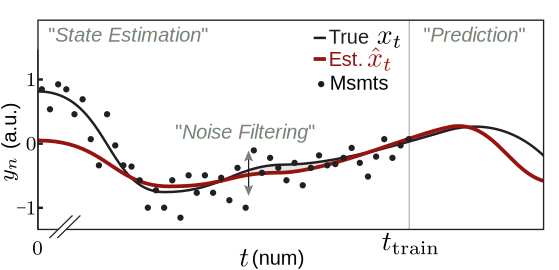

In [3]:
SVG(filename='webinar_overview_1.svg')

#### Approach:

1. Introduction to the State Space framework 

2. Applications

    2.1 Sinusoidal Kalman Filter (SKF)

    2.2 Autoregressive Kalman Filter (ARKF)

3. Example of a Non-Stationary, Transient Signal in Experiment

   3.1 Parameter Estimation of a Damped Chirp-like Signal
   
   3.2 Using a Linear Autoregressive Representation (ARKF)
   
   3.3 Using a Linear Time-Frequency Representation (Livska KF)

We won't be doing algorithmic tuning, training or performance characterisation in this webinar. 

#### References:

[1] Gelb, Arthur, ed. Applied optimal estimation. MIT press, 1974.

[2] Zarchan, Paul, and Howard Musoff, eds. Fundamentals of Kalman filtering: a practical approach. American Institute of Aeronautics and Astronautics, Inc., 2013.

[3] Candy, James V. Signal processing: model based approach. McGraw-Hill, Inc., 1986.

[4] Candy, James V. Bayesian signal processing: classical, modern, and particle filtering methods. Vol. 54. John Wiley & Sons, 2016.

[5] Mohinder, S. Grewal, and P. Andrews Angus. "Kalman filtering: theory and practice using matlab." John Wileys and Sons (2001).

[6] Liška, Jindřich, and Eduard Janeček. "Time-Frequency Representation of Signals Using Kalman Filter." Robotics, Automation and Control (2008): 23.

[7] Gupta, Riddhi Swaroop, and Michael J. Biercuk. "Machine learning for predictive estimation of qubit dynamics subject to dephasing." Physical Review Applied 9.6 (2018): 064042.

[8] Djuric, Petar M., and Steven M. Kay. "Parameter estimation of chirp signals." IEEE Transactions on Acoustics, Speech, and Signal Processing 38.12 (1990): 2118-2126.

### 1. State Space Framework

The state-space framework is about estimating the the state $x_t$ from measurements $y_t$, which are in general vector values random sequences in $t$. 

Given a set of measurements, $Y_{0:t} = \{ y_0, y_1, ... y_t \}$:

- _state estimation_ $\to$ estimating $x_{t'}$ for any $t' \leq t $. This is fitting existing data.
- _filtering_ $\to$ estimating $x_t$ from noisy measurements
- _prediction_ $\to$ estimating $x_{t''}$ for any $t'' \geq t$. This is forecasting the state once data collection has stopped at $t$. 

In this framework, the true state $x_t$ is:
- evolving in time according to the dynamics $f(\cdot)$
- observed via measurement procedure $h(\cdot)$

All examples in Section 2 will take the global form:

\begin{align}
x_t & = f(x_{t-1}) + w_t \\
y_t & = h(x_{t}) + v_t \\
w_t & \sim N(0, Q_t)\\
v_t & \sim N(0, R_t) \\
\end{align} Here, $t$ represents the index of measurements, and we can just think of it has denoting discrete time index, with equally-spaced time steps, $\Delta_t$.

There are two sources of uncorrelated, additive Gaussian white noise $w(\cdot)$ and $v(\cdot)$ describing imperfect dynamics and noisy measurements respectively. The set of equations above can be considered a map (filter) from two noise sources $w(\cdot)$ and $v(\cdot)$ to the sequence of random variates (observations) $y_t$. 

-------
What forms of $f(x_{t-1}), h(x_{t}) $ are allowed?:   

- **Linear-(izable)**: When $f(x_{t-1}), h(x_{t}) $ are linear in $x$, we can write $f(x_{t-1}) \to F_t x_{t-1}$ and similarly $h(x_{t}) \to H_t x_{t} $. When $f(x_{t-1}), h(x_{t}) $ are non-linear in $x$, one uses the Jacobian matrices for $f(x_{t-1}), h(x_{t})$. 
- Time / State Dependent $F_t, H_t$ : In general, dynamical model and measurement model can both change in time. $H_t$. The measurement procedure $H_t$ can implicitly depend on $x_t$.
- Observability of $x$: The matrix representations of $f(x_{t-1}), h(x_{t}) $ must satisfy certain criteria  to ensure that $x$ is actually observable from data under these transformations. 

------------------------------------------------------------------------------------------


** So how to we turn this into an algorithm that does state estimation / filtering / prediction? **

References: Chapter 4 of [5].

Minimize expected value of squared loss by seeking an estimator of $x_t$, denoted $\hat{x}_{t}$, that is some linear combination of previous estimates: $\hat{x}_{t-1}$ and incoming measurement $y_t$ i.e.
\begin{align}
\hat{x}_t: &= \mathbb{E}[x_t] \\
\hat{x}_t^{(+)} & = \lambda_t \hat{x}_{t-1}^{(+)} + \gamma_t y_t \\
 & = \lambda_t \hat{x}_{t}^{(-)} + \gamma_t y_t
\end{align} Here, ${}^{(-)}$ and ${}^{(+)}$ means the estimated quanities before and after a measurement is received in the same time-step $t$. 

This eventually gives a solution: $\gamma_t = \hat{P}_t^{(-)}H_t'(H_t \hat{P}_t^{(-)}H_t' + R_t)^{-1}$, and $\lambda_t = \mathbb{1} - \gamma_t H_t$. Here, we introduce a quantity $P$ as the co-variance matrix of $x$, and this is given by: $\hat{P}_t^{(\pm)}:= \mathbb{E}[(\hat{x}_{t}^{(\pm)} - x_t)(\hat{x}_{t}^{(\pm)} - x_t)']$, where $'$ denotes a transpose.

These solutions are substituted back into the estimator $\hat{x}_t^{(+)} = \lambda_t \hat{x}_{t}^{(+)} + \gamma_t y_t$. The substitution leads to all terms at the same $t$. Hence, more manipulation is required and we eventually get a set of recursive equations that solve minimisation problem defined over our state space framework. The ordered set of filtering equations are:

\begin{align}
&\text{Bring previous posterior estimates into current time step} \\
\hat{x}_t^{(-)} & = F_{t-1} \hat{x}^{(+)}_{t-1} \\
\hat{P}_t^{(-)} &= F_{t-1} \hat{P}_{t-1}^{(+)} F_{t-1}' + Q_{t} \\
&\text{Compute the Kalman gain} \\
\gamma_t &= \hat{P}_t^{(-)} H_t'(H_t\hat{P}_t^{(-)}H_t' + R_t)^{-1}\\
&\text{Predict a one-step ahead measurement} \\
\hat{y}_t^{(-)} & = h(\hat{x}_t^{(-)}) \\
&\text{Recieve an actual measurement and update state variables} \\
\hat{x}_t^{(+)} &= \hat{x}_t^{(-)} + \gamma_t (y_t - \hat{y}_t^{(-)}) \\
\hat{P}_t^{(+)} &= \left[1  - \gamma_t H_t \right] \hat{P}_t^{(-)}
\end{align}

Here, $\gamma_t$ is called the Kalman gain:
-  If the measurement noise variance $R_t$ is high, then the incoming measurement gets proportionally less weight in the estimator, and we rely more on previous state estimates.
- For this solution to work, the inverse term in the Kalman gain, $(H_t\hat{P}_t^{(-)}H_t' + R_t)^{-1}$, must be symmetric and positive definite at each iteration $t$.
- Whereas $Q_t$ can be safely set close to zero, in most practical cases, a non-zero and postive $R_t$ is required for $(H_t\hat{P}_t^{(-)}H_t' + R_t)^{-1}$ to be invertible.
- To enable prediction, $\gamma_t$ is set to zero, and the system evolves according to dynamics alone.
- If the form of $H_t$ has no (implicit) dependence on $x_t$, then the Kalman filter decouples into (a) measurement based updates of $x_t$ and (b) discrete time Ricatti recursive update for $P_t$... this is means that the optimal Kalman gain can be pre-computed and loaded into hardware.

\begin{align}
&\text{Ricatti equations for $P_t$} \\
\hat{P}_t^{(-)} &= F_{t-1} \hat{P}_{t-1}^{(+)} F_{t-1}' + Q_{t} \\
\gamma_t &= \hat{P}_t^{(-)} H_t'(H_t\hat{P}_t^{(-)}H_t' + R_t)^{-1}\\
\hat{P}_t^{(+)} &= \left[1  - \gamma_t H_t \right] \hat{P}_t^{(-)} \\
&\text{Measurement update for $x_t$} \\
\hat{x}_t^{(-)} & = F_{t-1} \hat{x}^{(+)}_{t-1} \\
\hat{y}_t^{(-)} & = h(\hat{x}_t^{(-)}) \\
\hat{x}_t^{(+)} &= \hat{x}_t^{(-)} + \gamma_t (y_t - \hat{y}_t^{(-)}) 
\end{align}


#### How do we design a filtering algorithm?

In practice, we don't really know how to construct the state space framework. There is more than one way to specify $x_t$. In turn, the choice of $x_t$ will govern the design of $F_t, H_t$ and we often have imperfect (or no) knowledge of $(x_0, P_0, R_t, Q_t)$. Typically:

1. $x_t$: The structure of $x_t$ is determined by what parameters we want to estimate
2. $x_0, P_0$: The initial prior $N(x_0, P_0)$ is set by apriori considerations (e.g. physical constraints) and our chosen method to model our remaining ignorance
3. $F_t$: A state transition matrix - often the continuous time differential equations for $x$ are brought into an (approximate) discrete-time, matrix representation using expansions of matrix exponentials
4. $H_t$: The measurement model specifies the mathematical relationship between $x_t$ and the observed data
5. $R_t$: Measurement noise covariance matrix is probably the most "physical" concept as it directly links to white noise affecting observations.
6. $Q_t$ Process noise covariance matrix... what is process noise? 

Process noise $w_t$ can be:
- a physical white noise source that accounts for imperfect or unknown dynamical evolution
- a practitioner's lever via $Q_t$ to force an algorithm to explore the state space of $x_t$ 
- a theoretical abstraction to describe how a white noise input ($w_t$) is transformed to account for temporal correlations in data

Example: Under identity dynamics and no process noise, $F_t = \mathbb{1}$ and $w_t = Q_t = 0 $ for all $t$, the above equations represent a recursive least squares solution.

*Not covered in this webinar: checking matrix representations of our model ensure observability, controllability

** In what situations do we expect our filters to work?**

The state space framework allows us to study a vast range of systems that can be described as "linear systems driven by white Gaussian noise". In this webinar, we have focussed on discrete time steps; but these tools apply to continuous time.  

However, in practice, many systems are non-linear either in their dynamical evolution or their measurement procedure or both. Here, the state space framework in discrete time uses an approximate linear matrix representation for a non-linear operator. While the non-linear model can be used inside the filter, the linear matrix representation (even if its an approximation) is often require to propagate the Ricatti equations. 

The framework above describes a map from two Gaussian white noise sources (process and measurement noise) to a (vector valued) sequence of random observations. The state $x$ and the state variance $P$ describe the first two moments of the conditional distribution of the true state $x$ on the observed data. The properties of these random variates can be relaxed in several ways. Non-white, temporally correlated noise is incorporated by re-defining the state $x$ and/or by adding an extra set of linear transformations to "shape" the process noise term $w_t$.

Typically in filtering, one assumes underlying random variates are wide sense stationary^ [1] even if associated with an unknown power spectral density. Further, we assume erogodicity, such that a sensible prediction problem can be defined [1]. However, in practice, time series data need not represent stationary random processes over a finite observation period - switching on, amplitude damping or transience, a non-linear instantaneous phase are common examples. Some of these non-stationary random processes can be accomodated within a linear state estimation and prediction framework by transforming to an appropriate theoretical representation e.g. using a Hilbert transform in [6, 8].

^ Stationary signals satisfy: (i) correlations between two random variates only depend on their separation distance; (ii) random processes which can be approximately written as trigonmetric polynomials where each term has a time-invariant coefficient over the observation period. A formal definition of stationarity and associated properties is in [1].


## 2. Applications

In all applications, there is some book-work required to figure out how to design a filter. In this webinar, we only want to take these methods on an "as-is" basis and develop an intuition for how they work without getting bogged down in derviations. 

In creating test-functions and analysis, we know from Fourier theory that $\Delta t \Delta f = 1/N$ where $N$ is the number of points, and $\Delta t, \Delta f$ are the resolutions in time and frequency domain. Hence, we choose $\Delta t, N$ and $\Delta f$ is then fixed. For sinusoidal test-functions, I generate these with a randomly chosen frequency $ f \in [2\Delta f, 10\Delta f]$ - this means we aren't aliasing.

In [4]:
t_train = 100
t_predict = 20
t_steps = np.arange(0, t_train + t_predict )
delta_t = 1
delta_f = 1./(t_train*delta_t)
print("delta_f: %s Hz" %(np.round(delta_f,3)))

delta_f: 0.01 Hz


### 2.1 -- Tracking a Sinusoid in Discrete Time

The problem of tracking a sinusoid is non trivial because we seek a set of linear transformations to approximately describe a non-linear trajectory for "small enough" time steps.  Secondly, there is also no single way to track a sinusoid in  the state space framework - see, for example, the set of filters described for tracking sinusoidal signals in [2], [5] and [6].  

Since in physics we may have come across the linearised dynamics of an oscillator before, where the estimator $x$ is usually represents the displacement and velocity of an oscillator. I wanted to take an example from [2] that was slightly different, where $x$ represents frequency characteristics and amplitude of the signal:   

Suppose we have a continuous time signal:

\begin{align}
y(t) &= A \sin (\omega t + \theta) \\
 &= A \sin (\phi(t)), \quad \phi(t):= \omega t + \theta 
\end{align}

In continuous time, let $x(t) = [\phi(t), \omega(t), A(t)]$ be the set of parameters requiring estimation and let their first derivatives be $\dot{A}, \dot{\omega}= 0, \dot{\phi} = \omega$. In continous time, we can say that $ \dot{x}(t)= \Phi x(t)$ for no process noise, where $\Phi$ is the matrix in:

\begin{align}
 \begin{bmatrix} \dot{\phi} \\ \dot{\omega} \\  \dot{A} \end{bmatrix} = \begin{bmatrix} 0 & 1 & 0 \\  0 & 0 & 0 \\0 & 0 & 0  \end{bmatrix}  \begin{bmatrix}\phi \\  \omega \\  A \end{bmatrix} + \begin{bmatrix} 0 \\ w^{(1)} \\ w^{(2)} \end{bmatrix}
\end{align}

The process noise covariance matrix is $t$-invariant and consists of introducing uncorrelated zero mean Gaussian white random variables $w^{(i)}$ with variance $q_i$ into signal frequency ($i=1$) and amplitude ($i=2$):
\begin{align}
Q(t): Q = \begin{bmatrix} 0 & 0 & 0 \\  0 & q_1 & 0 \\0 & 0 & q_2  \end{bmatrix}
\end{align}
Similiarly, we can set the non-linear, state dependent measurement model in continuous time to be:
\begin{align}
h(x) := x^{(2)} \sin (x^{(0)}) \quad \forall t
\end{align}

The general procedure from moving these equations to continuous and discrete time is in many textbooks and consists of technical considerations that would be difficult to mention all at once here (e.g. see Chapter 2 of [5]). In summary, we solve the continuous time differential equations $ \dot{x}(t)= \Phi x(t) + w(t)$  to get linear combinations of the solutions of the form $ \propto e^{\Phi t}$ (homogenous part) and additional terms involving process noise (inhomogenous part). The matrix exponentials relating to the homogenous parts are then approximated (e.g. using a Taylor series, but other approximations are possible) to yield the matrix representation for infinitisimal time translations taking the state from $x_t$ to $x_{t+1}$. 

For now, it means we can derive the state transition matrix  $ F(\tau)$ for a small time translation $\tau$ and at any $t$ to first order as:

\begin{align}
 F(\tau) = \mathbb{1} + \Phi \tau  = \begin{bmatrix} 1 & \tau & 0 \\  0 & 1 & 0 \\0 & 0 & 1  \end{bmatrix}
 \end{align} Setting $\tau=\Delta t$ gives  the dynamical model for filtering, $F_t \equiv F(\Delta t) \quad \forall t$.
 
We also have to transform the continuous time process noise co-variance matrix,  $Q$, for the process noise, $w(t)$, using the state transition matrix, $ F(\tau)$ and by integrating over the time interval $\tau \in [0, \Delta t]$ to get:

\begin{align}
Q_t &:= \int_0^{\Delta t} F(\tau) Q F(\tau)' d\tau  = \begin{bmatrix} q_1(\Delta t)^3/3 & q_1 (\Delta t)^2/2 & 0 \\  q_1 (\Delta t)^2/2 & \Delta t q_1 & 0 \\0 & 0 & \Delta t q_2  \end{bmatrix}
\end{align}

The linear approximation to the measurement model is also a state dependent Jacobian matrix:

\begin{align}
 H_t =  \begin{bmatrix} \frac{\partial h}{\partial x^{(0)}}  & \frac{\partial h}{\partial x^{(1)}} & \frac{\partial h}{\partial x^{(2)}}\end{bmatrix}_t = [ x^{(2)} \cos(x^{(0)}) & \quad 0 & \sin(x^{(0)}) ]
\end{align}
 
Meanwhile, the measurement model results in a scalar $y_t$, so $R_t$ is a scalar value representing the variance of additive zero mean white Gaussian measurement noise $v_t$. 

References: [2]

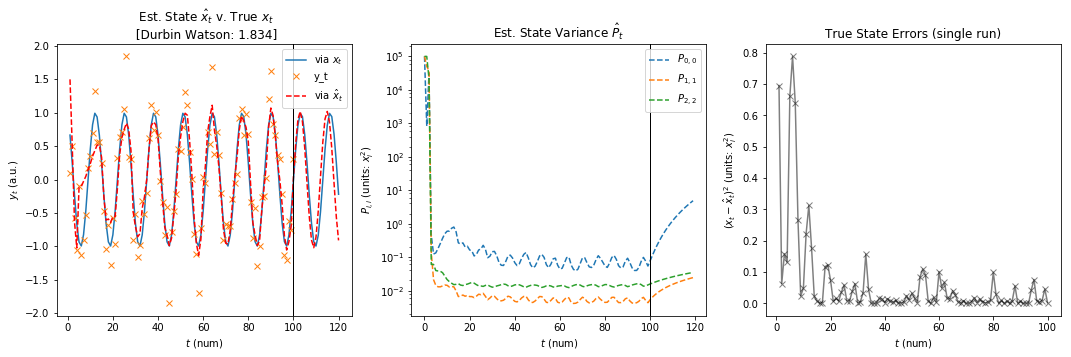

In [5]:
MODEL = "sinusoid"
if MODEL == "sinusoid":

    # Generate data
    true_R = 0.1
    truth, y_t, components = test_function(t_steps, MODEL, true_R)
    y_t=y_t[:-t_predict]
    
    # Specify Kalman Filter
    R_var= true_R
    dims = 3
    f_matrix = np.identity(dims)
    f_matrix[0, 1] = delta_t
    x0 = np.random.uniform(low=-5, high=5) * np.random.uniform()
    p0 = 100000.
    q1=0.01*true_R
    q2=0.01*true_R
    Q_var = np.zeros((dims, dims))
    Q_var[0,0] = delta_t**3 * q1 / 3.
    Q_var[0,1] = delta_t**2 * q1 / 2.
    Q_var[1,0] = Q_var[0,1]
    Q_var[1,1] = delta_t * q1 
    Q_var[2,2] = delta_t * q2 

    ## H is non linear and state dependent

    # Run Kalman filter
    output = kalman_filter(y_t, dims=dims, 
                           x0=x0, p0=p0,
                           Q_var=Q_var, R_var=R_var, 
                           f_matrix=f_matrix, h_matrix=None,
                           t_steps_ahead=t_predict,
                           non_lin_msmt_func=True,
                           state_dependent_h=True)

    # Get predictions from output
    predictions=[]
    for idx_t in t_steps:
        phi, omega, A = output[0][idx_t, :, 0]
        predictions.append(A*np.sin(phi))
        
    residuals = output[3][0:-t_predict]

    # Plot
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.title(" Est. State $\hat{x}_t$ v. True $x_t$ \n [Durbin Watson: %s]" %(np.round(durbin_watson(residuals),3)))
    plt.plot(t_steps + 1, truth, ls='-', label='via $x_t$')
    plt.plot(t_steps[0:-t_predict] + 1, y_t, 'x',label='y_t')
    plt.plot(t_steps + 1, np.asarray(predictions), 'r--',label='via $\hat{x}_t$')
    
    plt.axvline(x=t_train, ls='-', color='k', lw=1.)
    plt.xlabel(r'$t$ (num)')
    plt.ylabel(r'$y_t$ (a.u.)')
    plt.legend(loc=0)
    
    
    plt.subplot(1, 3, 2)
    plt.title(r"Est. State Variance $\hat{P}_t$")
    plt.plot(output[1][:, 0, 0], ls='--', label=r"$P_{0,0}$")
    plt.plot(output[1][:, 1, 1], ls='--', label=r"$P_{1,1}$")
    plt.plot(output[1][:, 2, 2], ls='--', label=r"$P_{2,2}$")
    
    plt.axvline(x=t_train, ls='-', color='k', lw=1.)
    plt.xlabel(r'$t$ (num)')
    plt.ylabel(r'$P_{i,i}$ (units: $x_i^2$)')
    plt.yscale('log')
    plt.legend(loc=1)

    errors = (truth - predictions)**2
    plt.subplot(1, 3, 3)
    plt.title("True State Errors (single run)")
    plt.plot(np.arange(t_train) + 1, errors[:-t_predict], 'kx-', alpha=0.5)
    plt.xlabel(r'$t$ (num)')
    
    
    plt.ylabel(r'$(x_t - \hat{x}_t)^2$ (units: $x_i^2$)')
    plt.show()

### 2.2 -- Tracking Time-Series Data via an Autoregressive Kalman Filter (ARKF)

Autoregressive models (AR) are constructed as a weighted sum of $n$ time-retarded samples of a process $f$, with weighting factors given by $\{\phi_n\}$:

\begin{align}
	f_t = \phi_1 f_{t-1} + \phi_2 f_{t-2} + ... + \phi_n f_{t-n} + w_t^{(0)}
\end{align} 
The Kalman state then re-organises the state $f_t$ as time-lagged vectors:
\begin{align}
	x_t & \equiv  \begin{bmatrix} f_{t} ...  f_{t-n+1} \end{bmatrix}^T \\
	w_t & \equiv \begin{bmatrix} w_{t}^{(0)} 0 ...  0 \end{bmatrix}^T \\
	F_t & \equiv 
	\begin{bmatrix}
		\phi_1 & \phi_2 & ...  & \phi_{n-1} & \phi_n \\ 
		1 & 0 & ...  & 0 & 0 \\  
		0 & 1 & \ddots & \vdots & \vdots \\ 
		0 & 0 & \ddots & 0 & 0 \\ 
		0 & 0 & ...  & 1 & 0 
	\end{bmatrix} \quad \forall t \\
	H & \equiv \begin{bmatrix} 1\;\;0\;\;0\;\;0... 0 \end{bmatrix} \quad \forall t
\end{align}

$R_t$ is a scalar and $Q_t$ depends only on the scalar variance $q^2$ of the process noise element $w_{t}^{(0)}$.

For $n$ lagged terms, the process $f$ is an AR process of order $n$, written AR(n). 

The AR family of random processes are as general as trigonometric polynomials for approximating any covariance stationary random process. AR processes can also parameterise non stationary, non-ergodic processes but the type of process depends on the coefficients of the AR model. 

Non-stationarity due to model mis-specifcation or unanticipated "trends" (e.g. linear drifts, exponential decay, seasonality)  can be analysed using the family of ARMA (or ARIMA) models. Thse extensions are obtained by adding lagged error terms (or increasing the order of difference equations) when designing $F_t$ [not in scope].

For small $n < 3$, it is possible to extract simple conditions on the coefficients, $\{ \phi_{n' \leq n} \}$, that guarantee properties of $f_t$.


- AR(1): For $\phi_1 > 0$ (low pass filter); $\phi_1 < 0$ (high pass filter); $\phi_1 = 1 $ (random walk)
- AR(2): For $\phi_2 < -0.25\phi_1^2$, mid frequency spectrum. For $\phi_2 > -0.25\phi_1^2$, the behavior is same as an AR(1) process for $\phi_1$. 

Below, we consider the case where we know the AR coefficients and run through examples of what these time series data look like:

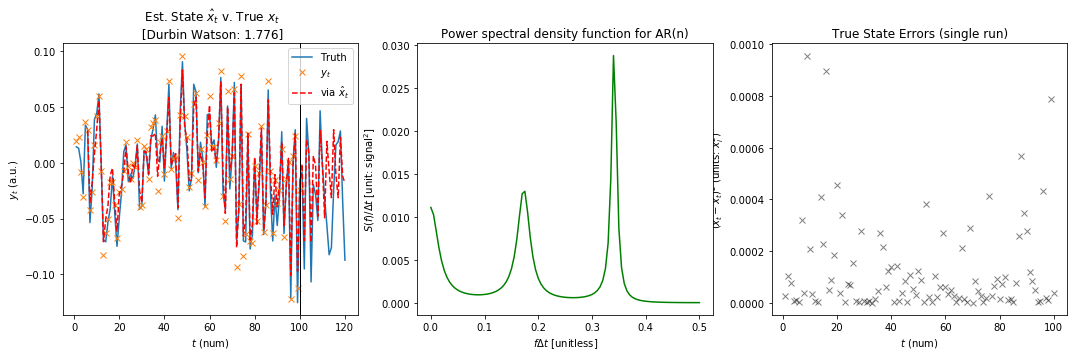

In [6]:
MODEL = "arkf"
if MODEL == 'arkf':

    # Generate data
    true_Q_var = 0.001
    true_R_var = 0.0001

#    # AR 1
#     order=1
#     phi_vector = np.zeros(order)
#     phi_vector[0] = -0.9 # high pass
#     # phi_vector[0] = +0.9 # low pass
#     # phi_vector[0] = 1. # random walk   

# #     # AR 2
#     order=2
#     phi_vector = np.zeros(order)
#     epsilon = -0.45 # complex roots, mid frequency
# #     epsilon = 0.1 # real roots, low or high pass depending on phi[0]
#     phi_vector[0] = +0.5 
#     phi_vector[1] = -1.0 * 0.25 * phi_vector[0]**2 + epsilon

#     AR 5 
    order=5
    phi_vector = np.zeros(order)
    phi_vector[0] = +0.7
    phi_vector[1] = -0.7
    phi_vector[2] = +0.7
    phi_vector[3] = -0.7
    phi_vector[4] = +0.7

    signal = np.zeros(t_train + t_predict + order)
    signal[0:order] = np.random.normal(loc=0, scale=np.sqrt(true_Q_var), size=order)
    for idx in range(order, t_train + t_predict + order, 1):
        signal[idx] = np.dot(phi_vector, signal[idx - order : idx][::-1])
        signal[idx] +=np.random.normal(0, scale=np.sqrt(true_Q_var))
    
    truth = signal[order:]
    y_t = truth  + np.random.normal(loc=0,scale=np.sqrt(true_R_var), size= t_train + t_predict)
    
    # Specify Kalman Filter
    
    R_var=true_R_var*5.
    p0 = 100000.
    f_matrix = get_autoreg_model(order, phi_vector)
    Q_var = np.zeros((order, order))
    Q_var[0, 0] = true_Q_var
    h_matrix = np.zeros((1, order))
    h_matrix[0,0] = 1.
    
    # Run Kalman filter
    output = kalman_filter(y_t[: -t_predict], dims=order, 
                           x0=y_t[0:order], p0=p0,
                           Q_var=Q_var, R_var=R_var, 
                           f_matrix=f_matrix, h_matrix=h_matrix,
                           t_steps_ahead=t_predict,
                           non_lin_msmt_func=False,
                           state_dependent_h=False)
    predictions_1 = np.asarray([np.dot(h_matrix, output[0][idx, :, 0]) for idx in range(t_train + t_predict)])
    
    if not RUN_RESTRICTED:
        predictions_2 = arkf("arkf", y_t, phi_vector, 
                             np.sqrt(Q_var[0, 0]), 
                             R_var, 
                             n_train=t_train-1, 
                             n_testbefore=t_train-1,
                             n_predict=t_predict+1, p0=p0)
    
    residuals = output[3][:-t_predict]
    
    # Plot
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.title(" Est. State $\hat{x}_t$ v. True $x_t$ \n [Durbin Watson: %s]" %(np.round(durbin_watson(residuals),3)))
    plt.plot(t_steps + 1, truth, ls='-', label='Truth')
    plt.plot(t_steps[0:-t_predict] + 1, y_t[0:-t_predict], 'x',label=r'$y_t$')
    plt.plot(t_steps[order:] + 1, predictions_1[order:], 'r--',label=r'via $\hat{x}_t$', alpha=1.)
    
    if not RUN_RESTRICTED:
        plt.plot(t_steps + 1, predictions_2, 'k-.',label='arkf', alpha=0.6)
    
    plt.axvline(x=t_train, ls='-', color='k', lw=1.)
    plt.xlabel(r'$t$ (num)')
    plt.ylabel(r'$y_t$ (a.u.)')
    plt.legend(loc=0)
    
    plt.subplot(1, 3, 3)
    errors_1 = (truth - predictions_1.flatten())**2
    plt.title("True State Errors (single run)")
    plt.plot(np.arange(t_train)+ 1, errors_1[:-t_predict], 'kx', alpha=0.5)
    
    if not RUN_RESTRICTED:
        errors_2 = (truth - predictions_2)**2
        plt.plot(np.arange(t_train)+ 1, errors_2[:-t_predict], 'kx--', alpha=0.5)
    
    plt.xlabel(r'$t$ (num)')
    plt.ylabel(r'$(x_t - \hat{x}_t)^2$ (units: $x_i^2$)')   
    
    freq = np.linspace(0., 0.5, 101)
    product_ = psd_ar(order, freq, phi_vector, true_Q_var)
    
    
    plt.subplot(1, 3, 2)
    plt.plot(freq, product_, 'g')
    plt.title('Power spectral density function for AR(n)')
    plt.xlabel(r'$f \Delta t$ [unitless]')
    plt.ylabel(r'$S(f) / \Delta t$ [unit: signal${}^2$]')
    plt.show()
    

Sophisticated methods exist for estimating model parameters of a general ARMA process to track a wide range of stationary and non-stationary random processes. A texbook introduction to ARMA estimation is found in [1].

For wide sense stationary random processes, a least squares analysis of data collected from a single run gives estimates for AR coefficients; these can be used for prediction (drift tracking) on other experiments under the same (similar) noise spectral densities [7].

### 3. Tracking a Damped Chirp-like Signal from Experiment

Experimentalists: Alistair Milne, Tim Fabian Wohlers-Reichel, Cornelius Hempel

We now have some lab diagnostic data for an ion trap constituting of a set of Ramsey measurements on a qubit. For each choice of wait time $\tau$, on the $x$-axis, the $y$ axis represents the average over many repeated single shot measurements yielding the excited state population $P_1$. 

The qubit is formed by the 'stretch states' of the Ytterbium trapped ion where qubit transition frequency depends on the magnitude of the magnetic field via the Zeeman effect (first order dependence). This means that the transition frequency for a qubit formed by these stretch states is very sensitive to magnetic field noise. 

One contribution to the magnetic field  noise is from the lab environment, e.g., power supplies and other electronic  devices.  Particularly  at  50 Hz  and  harmonics, noise arising from the mains electricity is commonly observed in the laboratory. 

The data below was taken to investigate the effect of a 50Hz AC Voltage line-cycle trigger that is anticipated to result in a 50 Hz sinsuoidal magnetic field amplitude. At smaller time-steps, the qubit transition frequency should change linearly to first order in the duration of the expertiment, and we see a chirp-like signal:

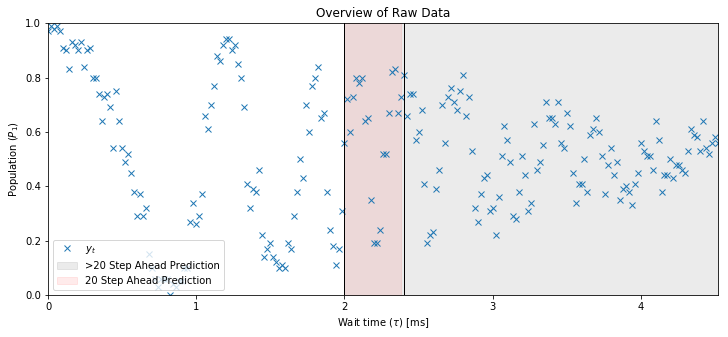

In [7]:
experimental_raw = np.load('./test.npz')['RamseyResults']

plt.figure(figsize=(12,5))
plt.title('Overview of Raw Data')
plt.plot(experimental_raw[:, 0], experimental_raw[:, 1], 'x', label=r'$y_t$')
plt.axvline(x = experimental_raw[t_train, 0], ls='-', c='k', lw=1.0)
plt.axvline(x = experimental_raw[t_train + t_predict, 0], ls='-', c='k', lw=1.0)
plt.fill_between(experimental_raw[t_train:, 0], 1.0, interpolate=True, color='k', alpha=0.08,
                label='>%s Step Ahead Prediction' %(t_predict))
plt.fill_between(experimental_raw[t_train: t_train+ t_predict, 0], 1.0, interpolate=True, color='r', alpha=0.08,
                label='%s Step Ahead Prediction' %(t_predict))
plt.xlabel(r"Wait time ($\tau$) [ms]")
plt.ylabel(r"Population ($P_1$)")
plt.ylim([0,1])
plt.xlim([0, experimental_raw[-1, 0]])
plt.legend(loc=3)
plt.show()


At longer wait-times, the experiment incurs more 'phase noise', i.e. jumps in the 50 Hz magnetic field amplitude that occur simply based on the instantaneous load of the various devices surrounding the trap (e.g. a cooling fan that adjusts its speed or starts/stops based on temperature of what it cools.)

If we implement a simple frequency chirp model, we assume that there is a single rate-of-change, which is not unreasonable in this case. However, there generally are also higher harmonics and other frequencies, so we don't expect a simple chirp model fit to work perfectly.

In [8]:
TRANSLATE=-0.5
experimental_data = np.zeros_like(experimental_raw)
experimental_data[:, 1] = experimental_raw[:, 1] + TRANSLATE 
experimental_data[:, 0] = experimental_raw[:, 0]
t_predict_ = 127
t_steps = np.arange(0, t_train + t_predict_ )
delta_t = (experimental_data[1, 0] - experimental_data[0, 0] )
delta_f = (1./(t_train * delta_t))

print("Spacing between wait time values:", delta_t, ("ms"))
print("Spacing in Fourier domain for %s points:"%(t_train), delta_f, ("kHz"))

Spacing between wait time values: 0.02 ms
Spacing in Fourier domain for 100 points: 0.5 kHz


### 3.1 Fitting a Damped Chirp-like Signal from Experiment

We test out the chirp model using a numerical fitting procedure on the first 100 data points (training data). We will define a loss function and use a simple optimisation procedure to extract the cofficients. 



Model parameter optimisation results:
      fun: 2.2117126891731593
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01005587,  0.00661613,  1.85597916, -2.9389185 ,  0.00886135])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 222
      nit: 14
   status: 0
  success: True
        x: array([ 2.66224964, -2.10466559,  5.        ,  0.5       ,  0.24353866])


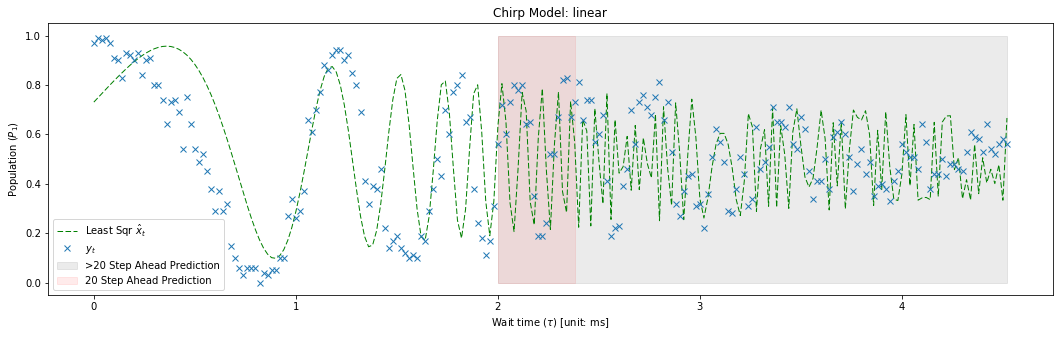

Model parameter optimisation results:
      fun: 1.0193837834888559
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.28481840e-04,  -6.77640625e-04,  -7.28349322e-04,
         3.91658615e-03,   5.74050767e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 480
      nit: 38
   status: 0
  success: True
        x: array([-1.87999698,  2.87398999,  2.49818011, -0.47658697,  0.15946842])


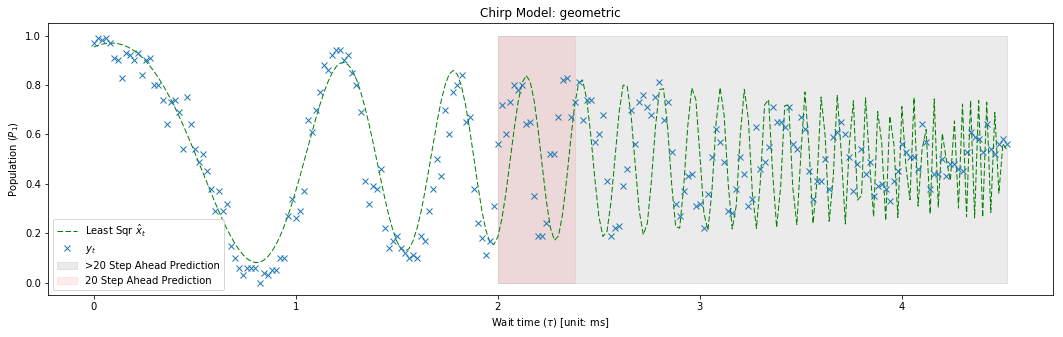

In [9]:
# The python function, loss_func, is accessing these variables outside of its local namespace
TRUNCATE=t_train 
DATA = experimental_data[:TRUNCATE, :] 

# Define how to configure optimiser based on type of chirp model
optconfig={}
optconfig["linear"] = {}
optconfig["linear"]["init"] = [0.1, 0.1, 0.1, 0.1, 0.1]
optconfig["linear"]["bnds"] = [(0, 2.*np.pi), (-5., 5.), (5., 100.), (-0.5, 0.5), (0, None)]
optconfig["geometric"] = {}
optconfig["geometric"]["init"] = [-np.pi, 3.8, 3, 0.5, 0.27]
optconfig["geometric"]["bnds"] = [(-np.pi, np.pi), (0, None), (0, None), (-0.5, 0.5), (0, None)]



for TYPE in ["linear", "geometric"]:
    
    # Define loss function for optimiser
    def loss_func(estimate_x, scaleup=100):
        '''Calculates residual MS error between measurements and model predictions.
        x0 - intial phase [dtype: scalar float]
        x1 - linear chirp coefficient in t [dtype: scalar float]
        x2 - geometric factor [dtype: scalar float]
        x3 - signal amplitude [dtype: scalar float]
        '''

        x0, x1, x2, x3, gamma = estimate_x
        predictions = damped_chirp(DATA[:, 0], x0, x1, x2, x3, gamma=gamma, typechirp=TYPE)
        loss = np.mean((predictions - DATA[:, 1])**2)*scaleup 

        return loss

    optimised_output = minimize(loss_func, optconfig[TYPE]["init"], 
                                method='L-BFGS-B', 
                                options={'eps': 0.001}, 
                                bounds=optconfig[TYPE]["bnds"])

    # Get optimised parameters from LS fit
    x0, x1, x2, x3, gamma = optimised_output['x']

    print("Model parameter optimisation results:")
    print(optimised_output)

    # Make some predictions
    test_points = experimental_data[:, 0]
    predictions = damped_chirp(test_points, x0, x1, x2, x3, gamma=gamma) - TRANSLATE
    y_t = experimental_data[:, 1] - TRANSLATE

    # Plot results against data
    plt.figure(figsize=(18, 5))
    plt.title("Chirp Model: %s" %(TYPE))
    plt.plot(experimental_data[:, 0], predictions, 'g--', label=r'Least Sqr $\hat{x}_t$', lw=1.)
    plt.plot(experimental_data[:, 0], y_t, 'x', label=r'$y_t$')

    plt.fill_between(experimental_data[t_train:, 0], 1.0, interpolate=True, color='k', alpha=0.08,
                    label='>%s Step Ahead Prediction' %(t_predict))
    plt.fill_between(experimental_data[t_train: t_train+ t_predict, 0], 1.0, interpolate=True, color='r', alpha=0.08,
                    label='%s Step Ahead Prediction' %(t_predict))
    plt.xlabel(r"Wait time ($\tau$) [unit: ms]")
    plt.ylabel(r"Population ($P_1$)")
    #plt.ylim([0,1])
    #plt.xlim([0, experimental_data[-1, 0]])
    plt.legend(loc=3)
    plt.show()


### 3.1 Using Linear Predictors for Non-Stationary, Transient Signals (AR(n) Representation)

Here, let's present that we choose an order for the AR model that is about 25% of the training data i.e. order = 25.
We then find the AR coefficients using a least squares approach (prototype) and then allow these coefficients to form the dynamical model of Section 2.3.



Optimisation success: True


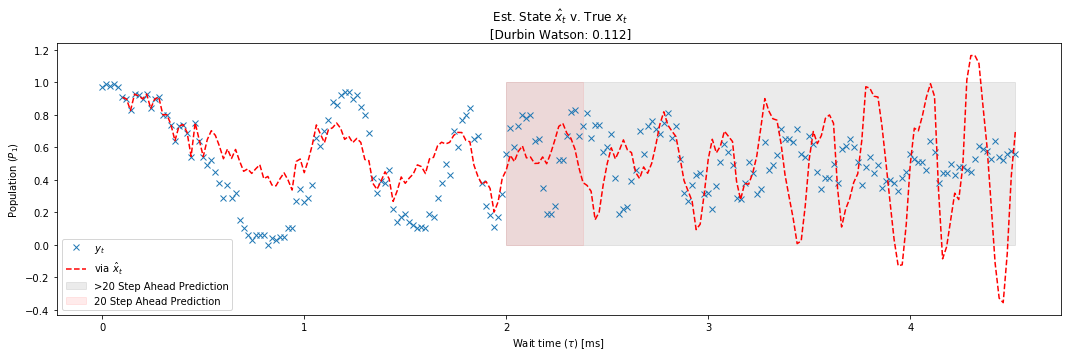

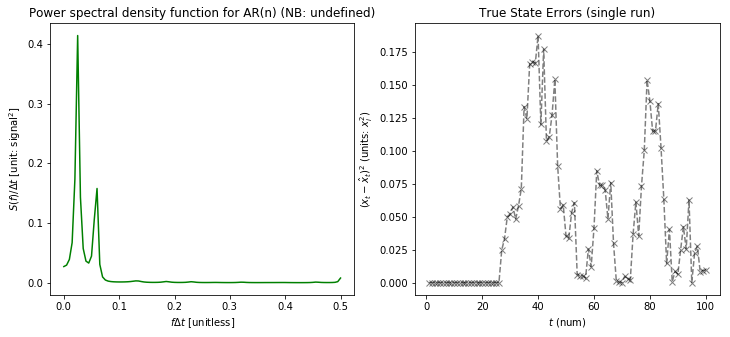

In [10]:
ar_order = 25

from scipy.optimize import minimize

signal = experimental_data[: t_train, 1]
ar_data_matrix = -1.*np.ones((ar_order, len(signal)))
for idx_vec in range(ar_order, len(signal)):
    ar_data_matrix[:, idx_vec] = signal[idx_vec - ar_order: idx_vec][::-1]
    
initial_phi = np.random.uniform(low=-2.5, high=2.5, size=ar_order)

def loss_func_ar(estimate_phi, SCALE_FACTOR=1):
    '''Calculates residual MS error between measurements and model predictions.
    estimate_phi : vector value sequence of length n that estimates coefficients for AR(n) model
    '''
    order = len(estimate_phi)
    predictions = np.sum(np.multiply(ar_data_matrix.T, estimate_phi).T,  axis=0)
    loss = np.mean((predictions[order:] - signal[order:])**2)
    
    return loss*SCALE_FACTOR

bounds= [(None, None)]*ar_order
optimised_output = minimize(loss_func_ar, initial_phi, method='L-BFGS-B', options={'eps': 0.0001}, bounds=bounds)
estimated_phi = optimised_output.x

print("Optimisation success:", optimised_output.success)
if optimised_output.success is False:
    print(optimised_output)

# Build Kalman model from estimate AR coefficients:
f_matrix = get_autoreg_model(ar_order, estimated_phi[::-1])
h_matrix = np.zeros((1, ar_order))
h_matrix[0,0] = 1.

# Set some values for the untuned parameters
R_var=1000
p0 = 100000.
Q_var = np.zeros((ar_order, ar_order))
Q_var[0, 0] = 0.01

y_t = experimental_data[0: t_train + t_predict_, 1] # during the training period, expect this to do well

# Run Kalman filter
output = kalman_filter(y_t[0 : - t_predict_], dims=ar_order, 
                       x0=y_t[0:ar_order], p0=p0,
                       Q_var=Q_var, R_var=R_var, 
                       f_matrix=f_matrix, h_matrix=h_matrix,
                       t_steps_ahead=t_predict_,
                       non_lin_msmt_func=False,
                       state_dependent_h=False)
predictions = np.asarray([np.dot(h_matrix, output[0][idx, :, 0]) for idx in range(t_train + t_predict_)])

residuals = output[3][:-t_predict_]

# Plot
plt.figure(figsize=(18, 5))
plt.title(" Est. State $\hat{x}_t$ v. True $x_t$ \n [Durbin Watson: %s]" %(np.round(durbin_watson(residuals),3)))

plt.plot(experimental_data[:, 0], experimental_data[:, 1] - TRANSLATE, 'x',label=r'$y_t$')
plt.plot(experimental_data[order: t_train + t_predict_, 0], predictions[order:] - TRANSLATE, 'r--',label=r'via $\hat{x}_t$', alpha=1.)

plt.fill_between(experimental_data[t_train:, 0], 1.0, interpolate=True, color='k', alpha=0.08,
                label='>%s Step Ahead Prediction' %(t_predict))
plt.fill_between(experimental_data[t_train: t_train+ t_predict, 0], 1.0, interpolate=True, color='r', alpha=0.08,
                label='%s Step Ahead Prediction' %(t_predict))
plt.xlabel(r"Wait time ($\tau$) [ms]")
plt.ylabel(r"Population ($P_1$)")
plt.legend(loc=3)
plt.show()    

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
errors = (y_t - predictions.flatten())**2

plt.title("True State Errors (single run)")
plt.plot(np.arange(t_train)+ 1, errors[:-t_predict_], 'kx--', alpha=0.5)
plt.xlabel(r'$t$ (num)')
plt.ylabel(r'$(x_t - \hat{x}_t)^2$ (units: $x_i^2$)')   

freq = np.linspace(0., 0.5, 101)

# For covariance stationary, zero mean Random processes:
product_ = psd_ar(ar_order, freq, estimated_phi, true_Q_var) 


plt.subplot(1, 2, 1)
plt.plot(freq, product_, 'g')
plt.title('Power spectral density function for AR(n) (NB: undefined)')
plt.xlabel(r'$f \Delta t$ [unitless]')
plt.ylabel(r'$S(f) / \Delta t$ [unit: signal${}^2$]')
plt.show()


What went wrong? The simple AR(n) structure assumed that major "trends" in the data have been accounted for, and the AR(n) part of the filter just characterises the left-over (wide sense stationary) noise. The non-linear instantaneous phase and the exponential amplitude decay  both violate stationarity conditions.

For non-stationary signals (e.g. non-linear phase signals either deterministic or random), a stationary approximation is used to analyse the Fourier transform of the signal (see, e.g. https://en.wikipedia.org/wiki/Chirp_spectrum), and some kind of spectrum estimate can be computed numerically for finite length signals (as we do above). However, for any signal that is not wide sense stationary, one cannot interpret or define a power-spectral density as a Fourier dual of the autocorrelation function of a signal.

Options for improving predictions: use ARIMA or ARMA models to incorporate exponential decay. Use "phase unwrapping" or "time-frequency representations" (see next, or [6,8]) to accomodate polynomial instantaneous phase. 

### 3.2 Using Linear Predictors for Non-Stationary, Transient Signals (Time-Frequency Representation)

In this example, we look at a sum of sinusoids with randomly chosen frequencies and non-stationary amplitudes. This application was originally presented in [6].

In this application, we will need to pick $J$ basis frequencies to form a computational basis for which to resolve our signal. This frequency basis doesn't have to be equi-spaced, but for this example, we pick  $\omega_{j}\equiv j\omega_0^{(B)}$ with $j$ an integer as $j = 1, ..., J^{(B)}$. 

The true hidden Kalman state, $x$, is represented as a collection of sub-states, $x^j$, for the $j^{th}$ harmonic component. Each $x^j$ consists of two parts $A^j_t$ and $B^j_t$  to help compute the instantaneous amplitude and instantaneous phases for each $\omega_j$.

\begin{align}
	x_{t} & \equiv \begin{bmatrix} x^{1}_{t} ... x^{j}_{t} ... x^{J^{(B)}}_{t} \end{bmatrix} \\
	A^j_{t} & \equiv \textrm{Re}(x^{j}_{t}) \\
	B^j_{t} & \equiv \textrm{Im}(x^{j}_{t}) \\
	x^j_{t} & \equiv \begin{bmatrix} A^j_{t} \\ B^j_{t}  \end{bmatrix}
\end{align} 
The algorithm tracks the real and imaginary parts of the Kalman sub-state simultaneously in order calculate the instantaneous amplitudes ($||{x^j_{t}}||$) and phases ($\theta^{j}_{t}$)  for each Fourier component:
\begin{align}
	||x^j_{t}|| & \equiv \sqrt{(A^j_{t})^2 + (B^j_{t})^2} \\
	\theta^{j}_{t} & \equiv \tan{\frac{B^j_{t}}{A^j_{t}}}
\end{align}

We stack $\Theta(j \omega_0^{(B)}\Delta t) $ for all $\omega_j$ along the diagonal to obtain the full dynamical matrix for $F_{t}$:
\begin{align}
	F_{t} & \equiv \begin{bmatrix} 
		\Theta(\omega_0^{(B)}\Delta t)... 0  \\ 
		... \Theta(j\omega_0^{(B)}\Delta t) ... \\
		0 ... \Theta(J^{(B)} \omega_0^{(B)}\Delta t)  \end{bmatrix}\\ 
	\Theta(j \omega_0^{(B)}\Delta t) &\equiv \begin{bmatrix} \cos(j \omega_0^{(B)}\Delta t) & -\sin(j \omega_0^{(B)}\Delta t) \\ \sin(j \omega_0^{(B)}\Delta t) & \cos(j \omega_0^{(B)}\Delta t) \\ \end{bmatrix} 
\end{align}

The measurement model, $H$, picks off the real part of each signal component, $A^j_{t}$, for each of the $J^{(B)}$ frequencies:
\begin{align}
	H & \equiv \begin{bmatrix} 1\;\;0 ... 1\;\;0 ... 1\;\;0 \end{bmatrix}
\end{align}

The extra theoretical modification in [6] is to add a state-dependent process-noise-shaping matrix $\Gamma_t$ to track non-stationary signals i.e. we replace $w_t \to \Gamma_t w_t$:
\begin{align}
	\Gamma_{n-1} &\equiv \Phi_{n-1}\frac{x_{n-1}}{||x_{n-1}||}
\end{align}
$\Gamma_{t}$ depends on the state estimates $x_t$. If we assume that $q^2$ is the variance for process noise for all $t$ and $j$, then the covariance matrix for process noise with noise-shaping is:
\begin{align}
Q_t := q^2 \Gamma_{t}\Gamma_{t}^T
\end{align}

In [11]:
if not RUN_RESTRICTED:
    delta_t = 0.001 * 0.02 # actual time step in seconds
    delta_f = 1. / (delta_t * t_train) # actual frequency in Hz

    # Experimental data
    y_t = experimental_data[: t_train + t_predict_, 1] # Values beyond t_train will not be used.

    # Specify Kalman Filter
    x0 = 0.1*np.random.normal(loc=0, scale=0.01)
    p0 = 500
    max_f = delta_f * t_train 
    R_var = 1500 # not tuned
    Q_var = 0.1 # not tuned

    freq_basis = np.arange(0, max_f*0.5, delta_f) # not tuned

    # Run Kalman filter

    predictions, x_hat, residuals = kf_2017(y_t, t_train, t_train, t_predict_, delta_t, x0, p0, Q_var, R_var, 
                                            freq_basis,
                                            switch_off_save='Yes')

    # Plot
    plt.figure(figsize=(18, 5))

    plt.title(" Est. State $\hat{x}_t$ v. True $x_t$ \n [Durbin Watson: %s]" %(np.round(durbin_watson(residuals),3)))
    plt.plot(experimental_data[:, 0], y_t - TRANSLATE, 'x',label=r'$y_t')
    plt.plot(experimental_data[:, 0], predictions[:] - TRANSLATE, 'r.--',label=r'via $\hat{x}_t')

    # plt.axhline(y=predictions[t_train] - TRANSLATE)

    plt.fill_between(experimental_data[t_train:, 0], 1.0, interpolate=True, color='k', alpha=0.08,
                    label='>%s Step Ahead Prediction' %(t_predict))
    plt.fill_between(experimental_data[t_train: t_train+ t_predict, 0], 1.0, interpolate=True, color='r', alpha=0.08,
                    label='%s Step Ahead Prediction' %(t_predict))
    plt.xlabel(r"Wait time ($\tau$) [unit: $\mu s$]")
    plt.ylabel(r"Population ($P_1$)")
    plt.ylim([-0.1, 1.1])
    #plt.xlim([0, data[-1, 0]])
    plt.legend(loc=3)
    plt.show()


    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 2)
    plt.title(" Residuals (single run)")
    plt.plot(experimental_data[:t_train + 1, 0], (y_t[:t_train + 1] - predictions[:t_train + 1])**2, 'kx-', alpha=0.5)
    plt.xlabel(r'$t$ (num)')
    plt.ylabel(r'$(x_t - \hat{x}_t)^2$ (units: $x_i^2$)')
    #      plt.yscale('log')
    plt.subplot(1, 2, 1)

    num_tones = len(components)
    numf = len(freq_basis)
    num = len(t_steps)
    instantA = np.zeros((numf, num))
    instantP = np.zeros((numf, num))

    k = 1
    while (k < num):
        instantA[:, k], instantP[:, k] = calc_inst_params(x_hat[:, :, k])
        k = k + 1

    plt.plot(freq_basis/max_f, instantA[:, -1]**2, 'ro', label=r' $||\hat{x}_t^j||$',markersize=4.)
    for basis_freq in freq_basis:
        plt.axvline(x=basis_freq/max_f, ls='-', lw=0.5, c='lightblue', alpha=0.5)
    starttime=0
    plt.xlabel(r'$f_j \Delta t$ (unitless)')
    plt.ylabel(r'Est. $||\hat{x}_t^j||^2$ (signal variance)')
    plt.title(r'Instantaneous $||\hat{x}_t^j||^2$  vs. $f_j \Delta t$')


    fft_data = np.fft.fft(experimental_data[:, 1] - TRANSLATE)
    fft_freq = np.fft.fftfreq(len(experimental_data[:, 1]), d=delta_t)
    nhalf = len(fft_freq) //2

    subsystem_scaling = (1./ len(freq_basis))**2 

    plt.plot(fft_freq[0:nhalf] / max_f, subsystem_scaling * abs(fft_data[0:nhalf])**2, '--', alpha=0.7, lw=1., 
             label=r'via Re[FFT($y_t$)]${}^2$')
    plt.yscale('log')

    plt.legend(loc=0)
    plt.show()

THIS EXAMPLE WILL NOT LOAD IF RUN_RESTRICTED IS TRUE.
Below we display previously computed image data:


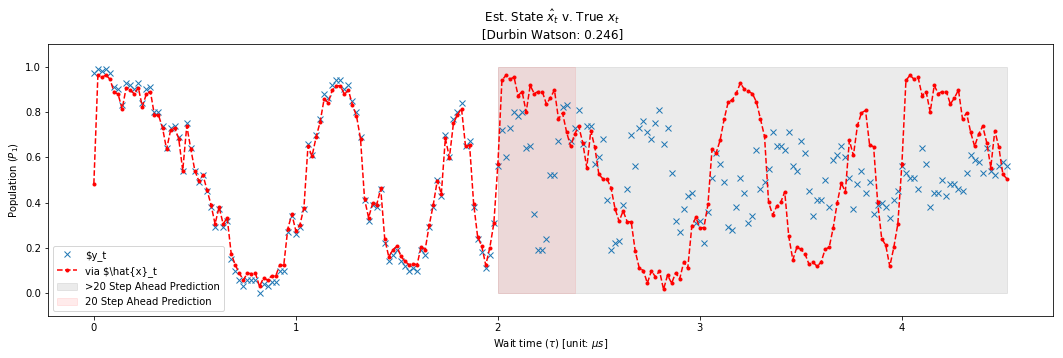

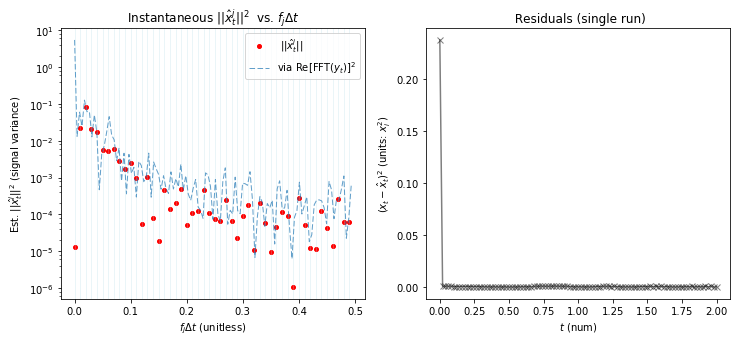

In [12]:
if RUN_RESTRICTED:
    
    print("THIS EXAMPLE WILL NOT LOAD IF RUN_RESTRICTED IS TRUE.")
    print("Below we display previously computed image data:")
    img1 = Image(filename='restricted_mode_1.png')
    img2 = Image(filename='restricted_mode_2.png')
    
    display(img1)
    display(img2)

Ideas for improvement? Providing a finer computational frequency basis, and observing for a longer period may enable the algorithm to learn instantaneous amplitude and phase information in greater detail. One can also tune noise variance parameters. Both these interventions may improve state estimation.

However, low state estimation errors may not lead to low errors during prediction for non-stationary signals. The physical change to improve the prediction horizon could be to measure faster relative to the change in time-series data such that the signal looks approximately stationary.  Indeed, we could also try and introduce amplitude damping independently in dynamical model to force the signal to decay for an apriori damping estimate - this forces amplitude damping and improves error metrics relating to prediction/forecasting but has no impact on the quality of instantaneous phase estimation. 

For a non transient chirp, a state space algorithm for estimating chirp parameters is given by [8] but background theory is different to the linear filtering and prediction models considered here. General time-frequency representations of non-stationary signals and their applications to time-series analysis is hence beyond the scope of this webinar. 